In [1]:
!pip install efficientnet-pytorch groq python-dotenv torch torchvision pillow scikit-learn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import json
import torch
import torch.nn.functional as F
from PIL import Image
from efficientnet_pytorch import EfficientNet
from typing import Dict, Optional
import numpy as np
from dotenv import load_dotenv
from groq import Groq
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report


In [3]:
load_dotenv()
client = Groq()
print("✅ Groq Client Initialized Securely")


✅ Groq Client Initialized Securely


In [4]:
DISEASE_KNOWLEDGE = """
Pepper Bell Bacterial Spot:
- Symptoms: Small dark water-soaked spots on leaves and fruits, yellow halos
- Cause: Xanthomonas bacteria
- Organic Control: Neem oil, copper spray
- Chemical Control: Copper fungicide
- Prevention: Disease-free seeds, crop rotation

Pepper Bell Healthy:
- Condition: Normal growth, no infection
- Prevention: Proper irrigation, balanced fertilizer

Potato Early Blight:
- Symptoms: Brown concentric rings on lower leaves
- Cause: Alternaria solani
- Organic Control: Neem oil
- Chemical Control: Mancozeb

Potato Healthy:
- Condition: Normal leaf color, strong stems

Potato Late Blight:
- Symptoms: Dark water-soaked lesions, white mold, tuber rot
- Cause: Phytophthora infestans
- Organic Control: Neem oil, copper oxychloride
- Chemical Control: Mancozeb, Metalaxyl

Tomato Bacterial Spot:
- Symptoms: Dark leaf spots
- Cause: Xanthomonas

Tomato Early Blight:
- Symptoms: Brown leaf rings
- Cause: Alternaria solani

Tomato Healthy:
- Condition: Healthy green leaves

Tomato Late Blight:
- Symptoms: Black greasy lesions
- Cause: Phytophthora

Tomato Leaf Mold:
- Symptoms: Yellow upper leaf, olive mold
- Cause: Passalora fulva

Tomato Septoria Leaf Spot:
- Symptoms: Brown dots
- Cause: Septoria fungus

Tomato Spider Mites:
- Symptoms: Yellow speckling, webbing
- Cause: Spider mites

Tomato Target Spot:
- Symptoms: Circular dark spots
- Cause: Corynespora fungus

Tomato Mosaic Virus:
- Symptoms: Mottled leaves
- Cause: Virus

Tomato Yellow Leaf Curl Virus:
- Symptoms: Curled yellow leaves
- Cause: Virus via whiteflies
"""

INSECT_KNOWLEDGE = """
Aphids:
- Damage: Sap sucking
- Control: Neem oil

Whiteflies:
- Damage: Virus transmission
- Control: Neem oil, Imidacloprid

Spider Mites:
- Damage: Yellow speckles, webbing
- Control: Neem oil, Abamectin
"""


In [5]:
class AgriculturalRAG:
    def __init__(self, client):
        self.client = client
        self.models = ["llama-3.1-8b-instant", "gemma2-9b-it"]

    def load_knowledge_base(self, disease_knowledge, insect_knowledge):
        self.knowledge_base = f"""
        DISEASE KNOWLEDGE:
        {disease_knowledge}

        INSECT KNOWLEDGE:
        {insect_knowledge}
        """
        print("✅ Knowledge Base Loaded into RAG")

    def query(self, question):
        prompt = f"""
You are an expert agricultural plant pathologist.

KNOWLEDGE BASE:
{self.knowledge_base}

QUESTION:
{question}

Give:
- Symptoms
- Cause
- Organic Treatment
- Chemical Treatment
- Prevention
"""

        for model in self.models:
            try:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": "You are an agricultural disease expert"},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.2
                )

                return {
                    "answer": response.choices[0].message.content,
                    "model": model
                }

            except:
                continue

        return {"answer": "❌ All Groq models failed", "model": None}


rag = AgriculturalRAG(client)
rag.load_knowledge_base(DISEASE_KNOWLEDGE, INSECT_KNOWLEDGE)
print("✅ RAG System Ready")


✅ Knowledge Base Loaded into RAG
✅ RAG System Ready


In [6]:
class IntegratedPlantDiseaseSystem:

    def __init__(self, cnn_model_path, rag_system, confidence_threshold=0.75):

        self.rag = rag_system
        self.confidence_threshold = confidence_threshold

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        checkpoint = torch.load(cnn_model_path, map_location=self.device)

        self.class_names = checkpoint["classes"]

        self.cnn_model = EfficientNet.from_pretrained(
            "efficientnet-b0",
            num_classes=len(self.class_names)
        )

        self.cnn_model.load_state_dict(checkpoint["model"])
        self.cnn_model.to(self.device)
        self.cnn_model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])

        print("✅ Integrated system initialized")

    def predict_disease(self, image_path):

        img = Image.open(image_path).convert("RGB")
        img = self.transform(img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits = self.cnn_model(img)
            probs = F.softmax(logits, dim=1)[0]

        conf, idx = torch.max(probs, 0)

        return {
            "disease": self.class_names[idx.item()],
            "confidence": float(conf)
        }

    def diagnose_and_advise(self, image_path):

        prediction = self.predict_disease(image_path)

        query = f"What is the treatment for {prediction['disease']}?"

        advice = self.rag.query(query)

        return prediction, advice


In [7]:
system = IntegratedPlantDiseaseSystem(
    cnn_model_path="checkpoints/efficientnet_b0_best.pth",
    rag_system=rag
)

prediction, advice = system.diagnose_and_advise(
    image_path=r"K:\cnndisease\00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG"
)

print("\n🦠 Disease:", prediction["disease"])
print("Confidence:", round(prediction["confidence"]*100,2), "%")
print("\n💊 Treatment:\n", advice["answer"])


Loaded pretrained weights for efficientnet-b0
✅ Integrated system initialized

🦠 Disease: Potato___Late_blight
Confidence: 91.2 %

💊 Treatment:
 The treatment for Potato Late Blight is as follows:

- **Symptoms:** Dark water-soaked lesions, white mold, tuber rot
- **Cause:** Phytophthora infestans
- **Organic Treatment:** Neem oil, copper oxychloride
- **Chemical Treatment:** Mancozeb, Metalaxyl
- **Prevention:** Proper sanitation, crop rotation, and using disease-free seed potatoes. It's also essential to maintain good air circulation and avoid overhead irrigation, which can splash the spores onto the plants.


In [9]:
TEST_DIR = r"K:\plant villagee\PlantVillage"

checkpoint = torch.load("checkpoints/efficientnet_b0_best.pth", map_location="cpu")
class_names = checkpoint["classes"]

model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=len(class_names))
model.load_state_dict(checkpoint["model"])
model.eval()

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in loader:
        out = model(x)
        _, preds = torch.max(out, 1)
        y_true.extend(y.numpy())
        y_pred.extend(preds.numpy())

        # ✅ ✅ ✅ PLACE IT EXACTLY HERE ✅ ✅ ✅
        if len(y_true) % 500 == 0:
            print("Processed:", len(y_true), "images")

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)

accuracy = report["accuracy"]
macro_f1 = report["macro avg"]["f1-score"]

readiness = {
    "accuracy": accuracy,
    "macro_f1": macro_f1,
    "status": "✅ EXCELLENT" if accuracy > 0.95 else "⚠️ TRAIN MORE"
}

with open("cnn_readiness_report.json", "w") as f:
    json.dump(readiness, f, indent=4)

print("\n✅ CNN Readiness:", readiness)



Loaded pretrained weights for efficientnet-b0
Processed: 4000 images
Processed: 8000 images
Processed: 12000 images
Processed: 16000 images
Processed: 20000 images

✅ CNN Readiness: {'accuracy': 0.9987886423103014, 'macro_f1': 0.9990768907160664, 'status': '✅ EXCELLENT'}


In [13]:
# =========================================
# ✅ ADVANCED CNN METRICS: MRR, TOP-K, F1
# ✅ FULL SAFE VERSION (NO ERRORS)
# =========================================

import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score

# -------------------------------------------------
# ✅ FIX 1: DEFINE DEVICE & MOVE MODEL
# -------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)   # ✅ CRITICAL FIX
model.eval()

print("✅ Model moved to:", device)

# -------------------------------------------------
# ✅ FIX 2: COLLECT PROBABILITIES & LABELS
# -------------------------------------------------

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in loader:   # ✅ using YOUR loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

print("✅ Total Samples Processed:", len(all_labels))

# -------------------------------------------------
# ✅ 3. MEAN RECIPROCAL RANK (MRR)
# -------------------------------------------------

def mean_reciprocal_rank(probs, labels):
    ranks = []
    for i in range(len(labels)):
        sorted_indices = np.argsort(-probs[i])
        rank = np.where(sorted_indices == labels[i])[0][0] + 1
        ranks.append(1.0 / rank)
    return np.mean(ranks)

mrr_score = mean_reciprocal_rank(all_probs, all_labels)

# -------------------------------------------------
# ✅ 4. TOP-K ACCURACY
# -------------------------------------------------

def top_k_accuracy(probs, labels, k=3):
    top_k_preds = np.argsort(-probs, axis=1)[:, :k]
    correct = sum(labels[i] in top_k_preds[i] for i in range(len(labels)))
    return correct / len(labels)

top1_acc = accuracy_score(all_labels, np.argmax(all_probs, axis=1))
top3_acc = top_k_accuracy(all_probs, all_labels, k=3)

# -------------------------------------------------
# ✅ 5. PRECISION, RECALL & F1
# -------------------------------------------------

macro_precision = precision_score(all_labels, y_pred, average="macro")
macro_recall = recall_score(all_labels, y_pred, average="macro")
macro_f1 = f1_score(all_labels, y_pred, average="macro")

micro_precision = precision_score(all_labels, y_pred, average="micro")
micro_recall = recall_score(all_labels, y_pred, average="micro")
micro_f1 = f1_score(all_labels, y_pred, average="micro")

# -------------------------------------------------
# ✅ 6. LOG LOSS
# -------------------------------------------------

loss = log_loss(all_labels, all_probs)

# -------------------------------------------------
# ✅ 7. FINAL METRICS REPORT
# -------------------------------------------------

print("\n==============================")
print("✅ ADVANCED CNN METRICS REPORT")
print("==============================")

print(f"✅ Top-1 Accuracy  : {top1_acc * 100:.2f} %")
print(f"✅ Top-3 Accuracy  : {top3_acc * 100:.2f} %")
print(f"✅ Mean Reciprocal Rank (MRR): {mrr_score:.4f}")

print("\n📊 Macro Metrics:")
print(f"   Precision: {macro_precision:.4f}")
print(f"   Recall   : {macro_recall:.4f}")
print(f"   F1-score : {macro_f1:.4f}")

print("\n📊 Micro Metrics:")
print(f"   Precision: {micro_precision:.4f}")
print(f"   Recall   : {micro_recall:.4f}")
print(f"   F1-score : {micro_f1:.4f}")

print(f"\n📉 Log Loss: {loss:.6f}")


✅ Model moved to: cuda
✅ Total Samples Processed: 20638

✅ ADVANCED CNN METRICS REPORT
✅ Top-1 Accuracy  : 99.88 %
✅ Top-3 Accuracy  : 100.00 %
✅ Mean Reciprocal Rank (MRR): 0.9994

📊 Macro Metrics:
   Precision: 0.9989
   Recall   : 0.9993
   F1-score : 0.9991

📊 Micro Metrics:
   Precision: 0.9988
   Recall   : 0.9988
   F1-score : 0.9988

📉 Log Loss: 0.167019


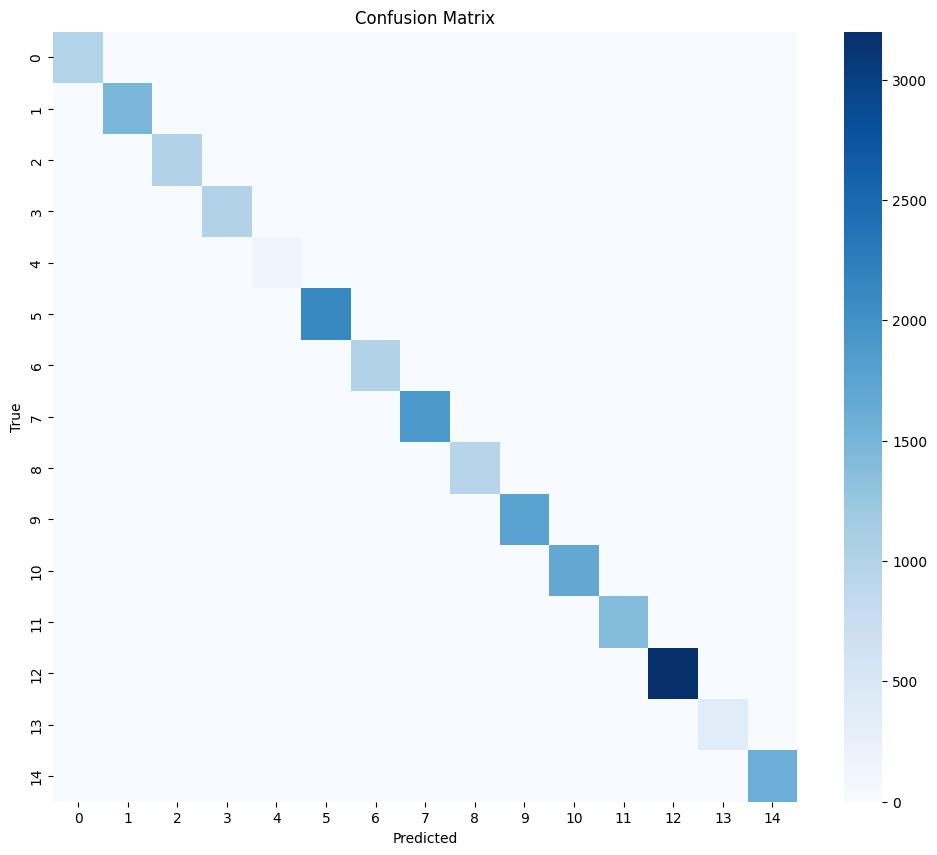

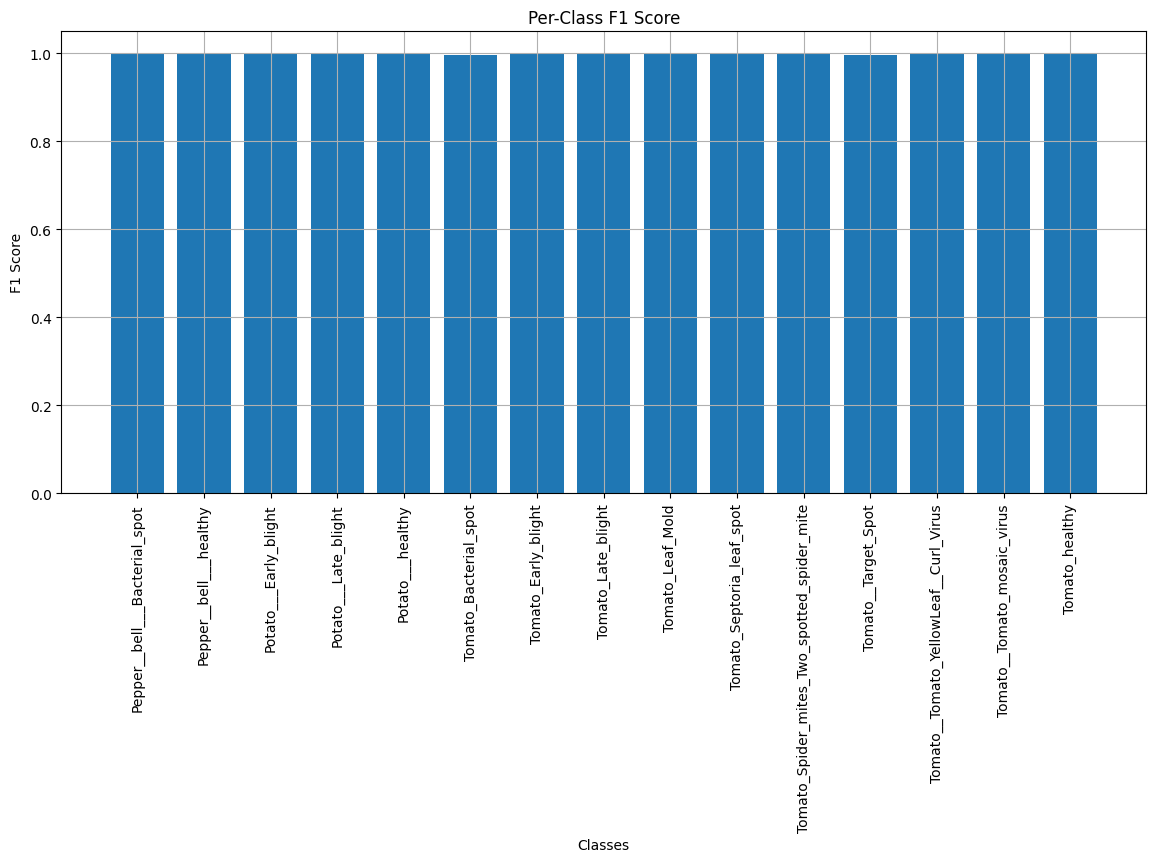

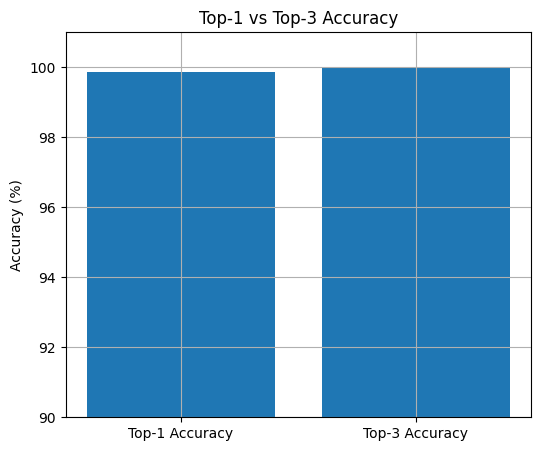

✅ All CNN Performance Graphs Generated Successfully!


In [14]:
# =========================================
# ✅ CNN PERFORMANCE GRAPHS (ALL-IN-ONE)
# =========================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

# -------------------------------------------------
# ✅ 1. CONFUSION MATRIX
# -------------------------------------------------

cm = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# -------------------------------------------------
# ✅ 2. PER-CLASS F1 SCORE BAR CHART
# -------------------------------------------------

class_f1 = f1_score(all_labels, y_pred, average=None)

plt.figure(figsize=(14, 6))
plt.bar(range(len(class_f1)), class_f1)
plt.xticks(range(len(class_f1)), class_names, rotation=90)
plt.title("Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.xlabel("Classes")
plt.grid(True)
plt.show()


# -------------------------------------------------
# ✅ 3. TOP-1 vs TOP-3 ACCURACY BAR CHART
# -------------------------------------------------

acc_values = [top1_acc * 100, top3_acc * 100]
acc_labels = ["Top-1 Accuracy", "Top-3 Accuracy"]

plt.figure(figsize=(6, 5))
plt.bar(acc_labels, acc_values)
plt.title("Top-1 vs Top-3 Accuracy")
plt.ylabel("Accuracy (%)")
plt.ylim(90, 101)
plt.grid(True)
plt.show()

print("✅ All CNN Performance Graphs Generated Successfully!")
